## Libraries 

In [7]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
%matplotlib inline

## Data Extraction 

In [8]:
df = pd.read_csv("drugsComTrain_raw.csv")

In [9]:
df.head(2)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192


In [10]:
df.nunique()

uniqueID       161297
drugName         3436
condition         884
review         112329
rating             10
date             3579
usefulCount       389
dtype: int64

## Data  Preprocessing

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
uniqueID       161297 non-null int64
drugName       161297 non-null object
condition      160398 non-null object
review         161297 non-null object
rating         161297 non-null int64
date           161297 non-null object
usefulCount    161297 non-null int64
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


We can notice from the information above that we have null values in only condition column. 

In [12]:
sum(df.isnull()['condition'])/len(df)

0.005573569254232875

In [13]:
#Since the totol number of rows with null values are less than 1% perct, we will drop those rows
df.dropna(inplace=True)
df.reset_index(inplace=True)

### Top 20 conditions with the total number of drugs exists in the dataset

In [14]:
conditionGroupDF = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
conditionGroupDF[:20]

condition
Not Listed / Othe                             214
Pain                                          200
Birth Control                                 172
High Blood Pressure                           140
Acne                                          117
Depression                                    105
Rheumatoid Arthritis                           98
Diabetes, Type 2                               89
Allergic Rhinitis                              88
Bipolar Disorde                                80
Osteoarthritis                                 80
Insomnia                                       78
Anxiety                                        78
Abnormal Uterine Bleeding                      74
Migraine                                       59
Psoriasis                                      58
Endometriosis                                  57
3</span> users found this comment helpful.     57
ADHD                                           55
Asthma, Maintenance                     

As we can see in the above information, we got few of the condition with "user found this comment usefull". And also there is a sequence of number in the beginning of this conditions. We will try to find all of those and will remove them since without an specific condition mentioned,evaluating them towards the drug and reviews will not be useful.

The first label on x-axis is names as not listed/others and it has highest count of different drug bought. For the time being we will replace those with "others".

### Removing rows which contains the unwanted information in condition column

In [15]:
len(df[df["condition"].str.contains("found",na=False)]['condition'])

900

In [16]:
x = df[df["condition"].str.contains("found",na=False)].index
df.drop(df.index[x],inplace=True)

### Replacing the content of all cells which have their condition as "Not Listed/ Others" to "Others"

In [17]:
df[df["condition"].str.contains("Listed",na=False)].head(2)

,index,uniqueID,drugName,condition,review,rating,date,usefulCount
708,711,88150,Clindamycin,Not Listed / Othe,"""Just an FYI to all on this medication. Diarrh...",8,2-Nov-13,5
1519,1530,176731,Lorazepam,Not Listed / Othe,"""For severe panic attacks, the only medication...",7,30-Aug-08,8


In [18]:
indexes = df[df["condition"].str.contains("Listed",na=False)].index
df.loc[indexes,'condition'] = "Others"

### Converting 10 point Likerts scale to 3 point scale for negative, neutral and positive class
We will using https://www.ibm.com/support/pages/node/422073 article by IBM and formula given in the article to convert the scales.

The formula says: Y = (B-A)* (x-a)/(b-a)+A
<p>Where a,b are the min and max of the scale to be converted, in our case a=1 and b=10
    
A,B are the min and max of the scale to be converted into, in our case A=1 and B=3</p>

In [19]:
A=1
B=3
a=1
b=10

df['sentiment'] = ((B-A)*(df['rating']-a)/(b-a)+A).astype(int)

### Dropping unnecessary columns
Since the index column is unnecessary and was added automatically when we tried to reset the index after dropping nas. Also, unique id doesn't contribute anything towards the analysis since the unique are just used to represent each row uniquely

In [20]:
df.drop(['index','uniqueID'],inplace=True,axis=1)

### Dropping rows with reviews count of a particular drug less than 2

In [21]:
droppedIndex = df.groupby(['drugName']).count().sort_values(by='condition')[:797].index
droppedIndex = df[df['drugName'].isin(list(droppedIndex))].index
df.drop(list(droppedIndex),inplace=True)

### Dropping rows with reviews count of a particular condition less than 2

In [22]:
droppedIndex = df.groupby(['condition']).count().sort_values(by='drugName')[:117].index
droppedIndex = df[df['condition'].isin(list(droppedIndex))].index
df.drop(list(droppedIndex),inplace=True)

In [23]:
df

,drugName,condition,review,rating,date,usefulCount,sentiment
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,2
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,2
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,1
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,2
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,2
...,...,...,...,...,...,...,...
160393,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125,3
160394,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34,1
160395,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35,1
160396,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79,3


In [24]:
df.reset_index(inplace=True)
df.drop(['index'],inplace=True,axis=1)

### Cleaning tweets

In [25]:
def clean_tweet(tweet): 
    return ' '.join(re.sub("&#039|&amp;|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [26]:
temp = []
for x in df['review']:
    temp.append(clean_tweet(x))
df['review'] = temp

### Saving processed data into a csv file

In [ ]:
df.to_csv("cleaned.csv")

# Exploratory Data Analysis

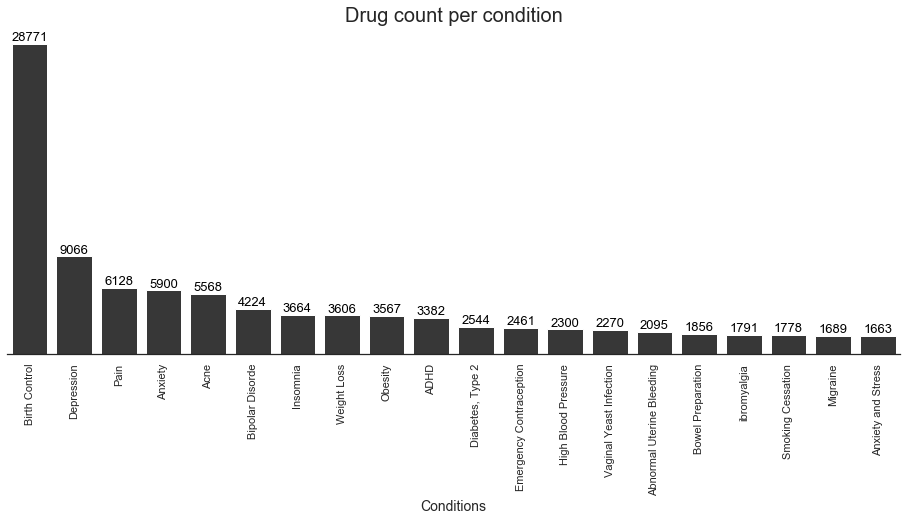

In [22]:
conditionDF = pd.DataFrame(df.groupby(['condition']).count().sort_values(by='usefulCount',ascending=False)['usefulCount'])[:20].reset_index()

plt.figure(figsize=(16,6))
sns.set(style="white")
g= sns.barplot(x="condition",y="usefulCount",data=conditionDF,color=(0.21569, 0.21569 ,0.21569))

g.set_xticklabels(rotation=90,labels=conditionDF['condition'])
g.set(yticklabels=[])
g.set_ylabel('')
g.axes.set_title("Drug count per condition",fontsize=20)
g.set_xlabel('Conditions',fontsize=14)
sns.despine(left=True)

locs, labels = plt.xticks() # get the current tick locations and labels

for loc, label in zip(locs, labels):
    count = conditionDF.iloc[loc].usefulCount
    plt.text(loc, count-8, '{:0.0f}'.format(count), ha='center', va='bottom' ,color = 'black',size=13)

From the above plot, condition "Birth Control" contains the highest number of reviews which is about 18% of the data followed by "Depression" approx 5% and "Pain" approx 3%.

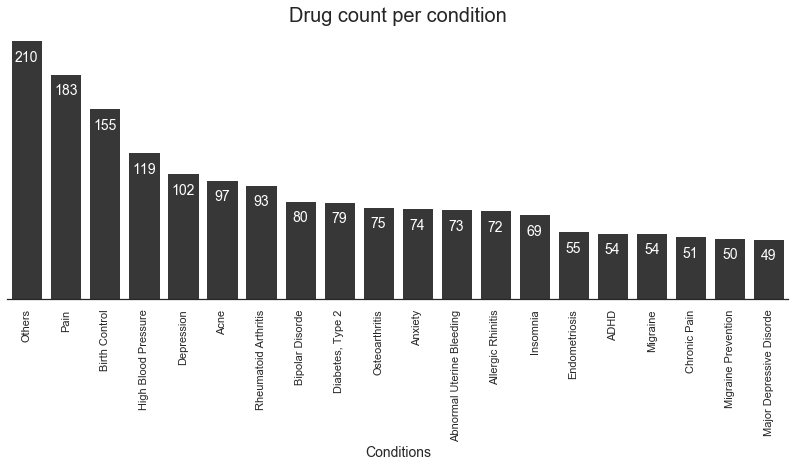

In [23]:
conditionGroupDF = pd.DataFrame(df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)[:20]).reset_index()

plt.figure(figsize=(14,5))
sns.set(style="white")

g = sns.barplot(y=conditionGroupDF['drugName'],x=conditionGroupDF['condition'],color=(0.21569, 0.21569 ,0.21569))

g.set_xticklabels(rotation=90,labels=conditionGroupDF['condition'])
g.set(yticklabels=[])
g.set_ylabel('')
g.axes.set_title("Drug count per condition",fontsize=20)
g.set_xlabel('Conditions',fontsize=14)
sns.despine(left=True)

locs, labels = plt.xticks() # get the current tick locations and labels

for loc, label in zip(locs, labels):
    count = conditionGroupDF.iloc[loc].drugName
    plt.text(loc, count-8, '{:0.0f}'.format(count), ha = 'center',va='top', color = 'w',size=14)

The above plot gives us the information about the number of different drugs available for each of the condition mentioned. We have plotted the top 20 condition in the decreasing order of their drugs count. The condition mentioned as "others" have the highest number of drugs available, it is since the specific condition isn't mentioned in this case. The second highest is the "Pain", it has 200 alternate drugs available. Painkillers drugs are widely sold drugs since they are used in all cases irrespective of age, gender and the critical conditions. The third most number of alternate drugs available are for the condition "Birth Control". According to wikipedia, in the United States 98% of sexually active women have used birth control at some point in time, and 62% of those of reproductive age are currently using birth control.

The later condition in the series also makes sense in real world, since blood pressure, acne, ADHD, depression, anxiety, insomnia are some of the common health condition and whose prescription people take without consulting a doctor. These condition are some of the most common causes in the world and there are thousands of alterative drugs available worldwide.

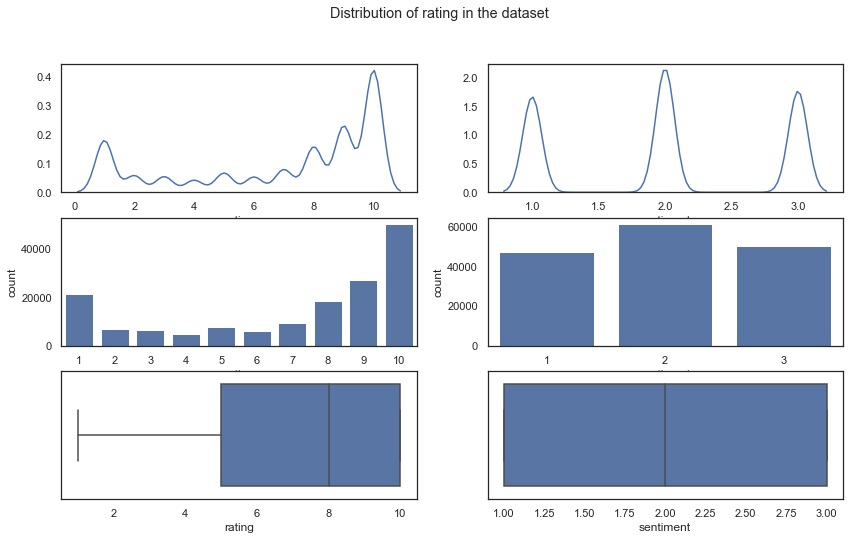

In [24]:
f, axes = plt.subplots(3, 2,figsize=(14, 8))
    sns.countplot(df['rating'],color=sns.color_palette()[0],ax=axes[1][0])
sns.distplot(df['rating'], hist=False,ax=axes[0][0])
sns.boxplot(df['rating'],ax=axes[2][0])
g.set_ylabel('Count',fontsize=12)
plt.suptitle("Distribution of rating in the dataset");

sns.countplot(df['sentiment'],color=sns.color_palette()[0],ax=axes[1][1])
sns.distplot(df['sentiment'], hist=False,ax=axes[0][1])
sns.boxplot(df['sentiment'],ax=axes[2][1])

From the plot, we have more than 50,000 reviews from the group of "rating 10" followed by "rating 9" with 27219 count. "rating 1" group is the contains the third most count with 21391. Rating group from 2 - 7 contains less than 10,000 reviews count. Also from box plot, we can notice that 50% of the data lies between 8 to 10 since the median of the plot is at 8 and the third quartile and max are at 10. The data is right skewed.

But after converting 10-point likerts scale into 3 point scale fro extracting the positve, neutral and negative reviews. The data is approximately normal without any skewness. 

In [25]:
xDate =[]
xMonth = []
xYear = []
for x in df['date']:
    t = x.split("\n")[0]
    xDate.append(t)
    xMonth.append(datetime.strptime(t, '%d-%b-%y').month)
    xYear.append(datetime.strptime(t, '%d-%b-%y').year)
df['date'] = xDate
df['month'] = xMonth
df['year'] = xYear

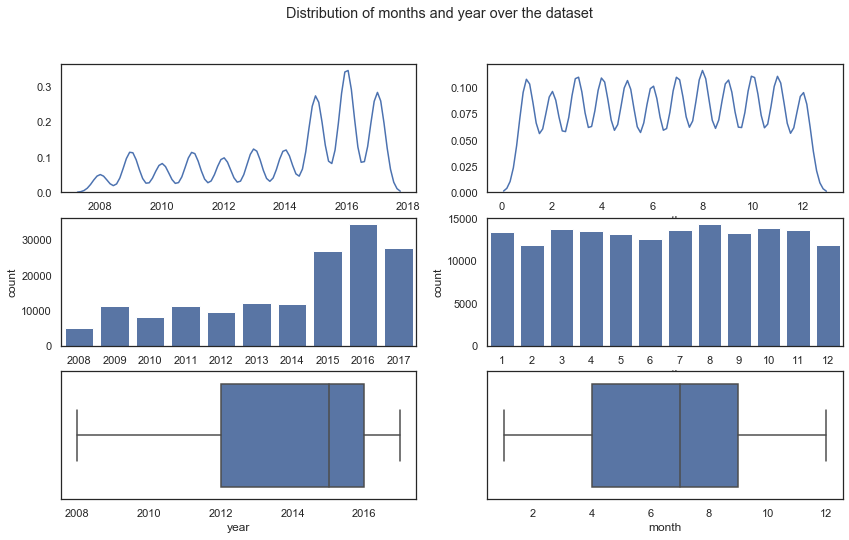

In [26]:
f, axes = plt.subplots(3, 2,figsize=(14, 8))
sns.countplot(df['year'],color=sns.color_palette()[0],ax=axes[1][0])
sns.distplot(df['year'],hist=False,color=sns.color_palette()[0],ax=axes[0][0])
sns.boxplot(df['year'],ax=axes[2][0])

sns.countplot(df['month'],color=sns.color_palette()[0],ax=axes[1][1])
sns.distplot(df['month'],hist=False,color=sns.color_palette()[0],ax=axes[0][1])
sns.boxplot(df['month'],ax=axes[2][1])

plt.suptitle("Distribution of months and year over the dataset");

The above plots shows the distribution of months and year over the dataset. As we see, more reviews have been collected in the later year after 2014. In 2016, maximum number of reviews was collected more than 30000 while both 2015 and 2016 share approximately same number of reviews with count around 28000. Also from the box plot, it shows that 50% of the data lies between 2012 to 2016 with median at 2015. 25% of the data lies between 2015 and 2016 only. 

When we tried to see the distribution of reviews over the months, we were not able to extract much information since the dataset is evenly distributed over the 12 months. 

In [27]:
#f,ax = plt.subplots(1,2,figsize=(14, 7))
#sns.jointplot(x ='rating', y ='year', data = df, kind ='kde',height=3,ax=ax[0],ratio=4)
#sns.jointplot(x ='rating', y ='year', data = df, kind ='kde',height=3,ratio=4,ax=ax[1])

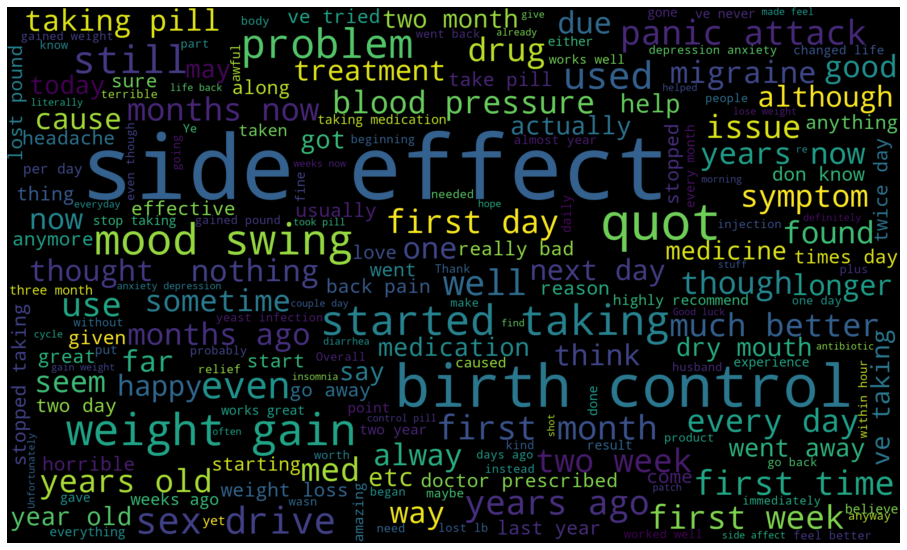

In [27]:
textData = []
for t in df.review:
    textData.append(t)
textData = pd.Series(textData).str.cat(sep=' ')

from wordcloud import WordCloud
wordcloud = WordCloud(width=2000, height=1200,max_font_size=200).generate(textData)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()